# Notebook 3: Exploratory Data Analytics

With deck and relic encodings complete, we'll step back and explore how the dataset **behaves**. The goal here is to build intuition about player behavior and model-relevant structure. We examine distributions of key variables (floor progression, HP, gold, deck size), look for class- and ascension-level patterns, and visualize how the deck embeddings evolve across a run.

This phase helps will help us catch anomalies, understand strategic trends across millions of runs, and guide the modeling choices that follow.

## Pandas Dataset Path Handlers

Lightweight shortcuts for loading preprocessed SVD parquet files into pandas.  
Use `DATASETS.C128.k1.load()` or `DATASETS.C64.full.load()` to access the desired dataset without hard-coding paths.

- `DATASETS`: the `namespace` object that holds all dataset handles.
- `.C128`: selects the 128-component SVD family (maps to `../128Component/`). *Alternatively use `.C64` to load the 64-component SVD family*
- `.k1`: picks the 1k-run slice within that family (loads `1k.parquet`). *Alternatively use `.k10` to load the 10k-run slice, and `.full` to load the full dataset*

`.load()` turns the formed path into a loaded pandas DataFrame from the parquet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

BASE_DIR = "/content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD"

# TODO: Migrate logic for AWS bucket downloads instead of copying from drive
class _Dataset:
  def __init__(self, base_dir: str, dim: int, name: str):
    self.path = os.path.join(base_dir, f"{dim}Component", f"{name}.parquet")
  def load(self, columns=None) -> pd.DataFrame:
    """Load the dataset into a pandas DataFrame"""
    return pd.read_parquet(self.path, columns=columns)

class _Dim:
  def __init__(self, base_dir: str, dim: int):
    # aliases: k1 / _1k, k10 / _10k, full
    self.k1   = _Dataset(base_dir, dim, "1k")
    self._1k  = self.k1
    self.k10  = _Dataset(base_dir, dim, "10k")
    self._10k = self.k10
    self.full = _Dataset(base_dir, dim, "full")

class DATASETS:
  C64  = _Dim(BASE_DIR, 64)
  C128 = _Dim(BASE_DIR, 128)

In [3]:
# For EDA we'll load the complete model into a HIGH-ram colab compute runtime
df = DATASETS.C128.full.load()

In [4]:
df.head(10)

,run_id,floor,victory,character,asc_level,deck_size,num_relics,max_hp,cur_hp,gold,...,deck_svd_118,deck_svd_119,deck_svd_120,deck_svd_121,deck_svd_122,deck_svd_123,deck_svd_124,deck_svd_125,deck_svd_126,deck_svd_127
0,18759847683600,0,False,IRONCLAD,0,11.0,1,72.0,72.0,114.0,...,0.005373,0.004568,0.043209,-0.019841,0.044052,-0.003375,0.008821,0.012429,-0.035523,0.029643
1,18759847683600,1,False,IRONCLAD,0,12.0,1,72.0,72.0,127.0,...,0.023894,0.011650,0.045542,-0.010784,0.036381,-0.003094,0.002893,0.010014,-0.029306,0.036024
2,18759847683600,2,False,IRONCLAD,0,13.0,1,72.0,72.0,127.0,...,0.028510,0.028210,0.034313,-0.010449,0.010496,-0.017408,0.000115,-0.008015,-0.007301,0.033082
3,18759847683600,3,False,IRONCLAD,0,14.0,2,72.0,72.0,127.0,...,0.021230,0.029339,0.025351,-0.014085,0.004469,-0.015599,-0.010306,-0.005257,-0.015817,0.034264
4,18759847683600,4,False,IRONCLAD,0,14.0,2,72.0,69.0,145.0,...,0.021230,0.029339,0.025351,-0.014085,0.004469,-0.015599,-0.010306,-0.005257,-0.015817,0.034264
5,18759847683600,5,False,IRONCLAD,0,15.0,2,72.0,49.0,177.0,...,0.025384,0.031180,0.020290,-0.003750,0.013815,-0.004680,-0.004003,0.008613,-0.013144,0.053839
6,18759847683600,6,False,IRONCLAD,0,15.0,3,72.0,49.0,177.0,...,0.025384,0.031180,0.020290,-0.003750,0.013815,-0.004680,-0.004003,0.008613,-0.013144,0.053839
7,18759847683600,7,False,IRONCLAD,0,15.0,3,72.0,52.0,193.0,...,0.094953,0.010739,0.073777,-0.124575,0.285490,0.011392,0.160518,0.071671,-0.096814,0.040254
8,18759847683600,8,False,IRONCLAD,0,16.0,3,72.0,52.0,193.0,...,0.113474,0.017822,0.076110,-0.115518,0.277819,0.011673,0.154590,0.069256,-0.090597,0.046635
9,18759847683600,9,False,IRONCLAD,0,16.0,4,72.0,42.0,223.0,...,0.113474,0.017822,0.076110,-0.115518,0.277819,0.011673,0.154590,0.069256,-0.090597,0.046635


## Basic EDA

What does our dataset look like? What is the average win percentage? What level of baseline accuracy should we expect?

<Axes: xlabel='floor', ylabel='Count'>

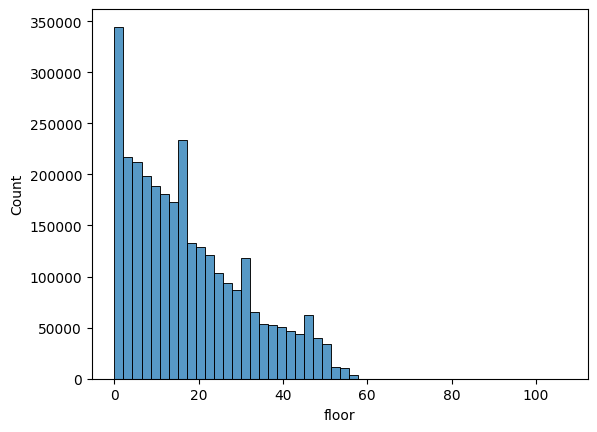

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histplot represents the general pattern of survival. We have fewer records for higher floor counts since every run
# is much more likely to have a floor 1, 2, 3 than a 40, 41, 42
sns.histplot(df['floor'], bins=50)

<Axes: xlabel='asc_level', ylabel='floor'>

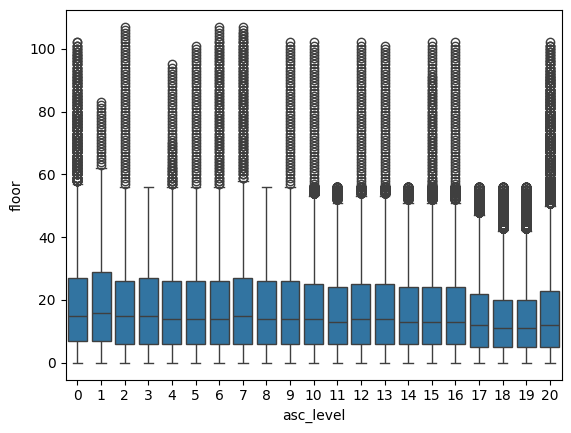

In [6]:
# Floors are median distributed around 15 regardless of selected difficulty. This is around the first boss fight, so this makes sense as a logical first choke point
sns.boxplot(x='asc_level', y='floor', data=df)

<Axes: xlabel='count', ylabel='character'>

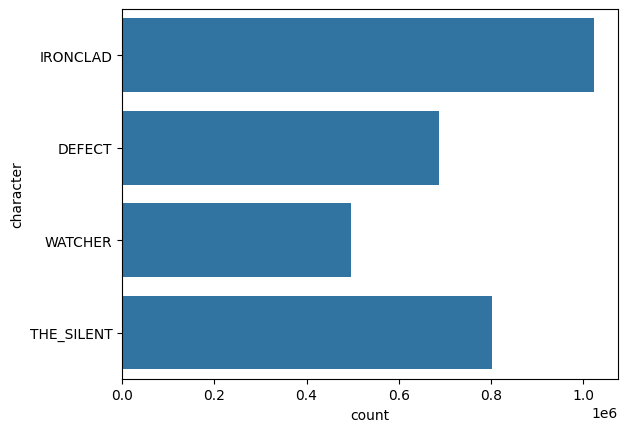

In [7]:
# We can build our models to predict using one-hot encoded character, since we have at least 400k records for each class
sns.countplot(df['character'])

### Victory Rate Analysis

In [8]:
# Around 20% of our records are attached to a winning run. This should act as our baseline for model prediction
df['victory'].value_counts(normalize=True)

,proportion
victory,
False,0.79566
True,0.20434


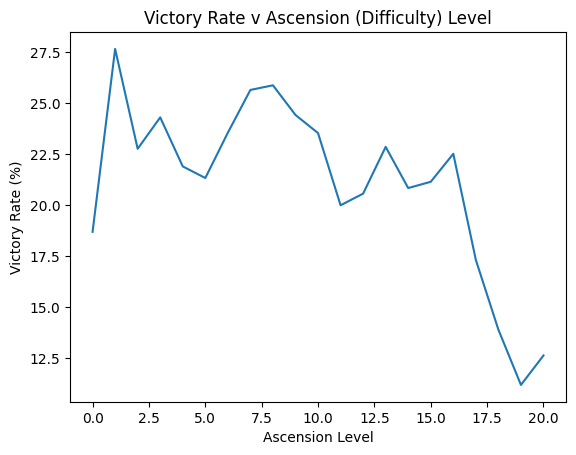

In [9]:
# Victory rate actually increases for ASC 1, likely because players who have already beaten the game once are more likely to beat the game on a slightly
# higher difficulty than players who just picked up the game and
victory_rate = df.groupby('asc_level')['victory'].mean().reset_index()
victory_rate['victory'] *= 100
sns.lineplot(data = victory_rate, x ='asc_level', y = 'victory')
plt.title("Victory Rate v Ascension (Difficulty) Level")
plt.xlabel("Ascension Level")
plt.ylabel("Victory Rate (%)")
plt.show()

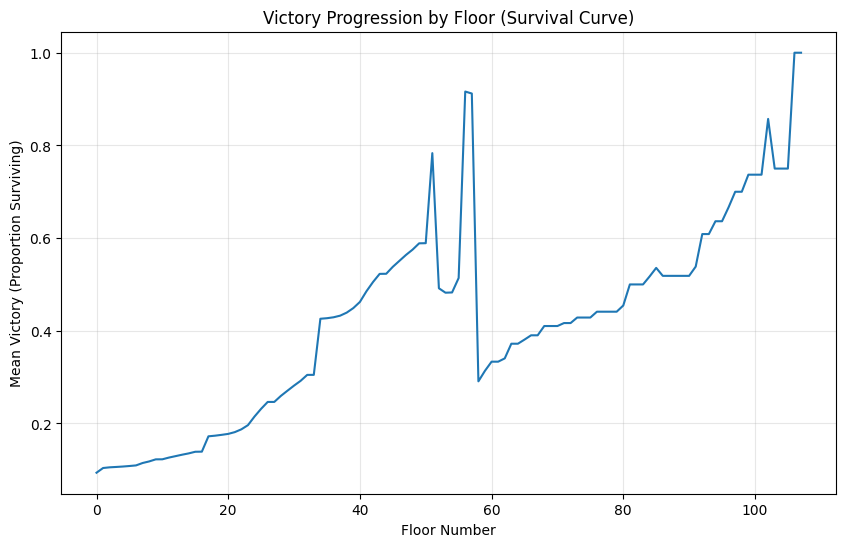

In [10]:
# Compute "alive" proportion per floor (mean of victory == 1 across all runs that reached that floor)
survival = df.groupby('floor')['victory'].mean().reset_index()

# We can realisticall ignore rusn that are more than 45 runs, since they are in the inifintite or extended game modes.
plt.figure(figsize=(10, 6))
sns.lineplot(data=survival, x='floor', y='victory')
plt.title('Victory Progression by Floor (Survival Curve)')
plt.xlabel('Floor Number')
plt.ylabel('Mean Victory (Proportion Surviving)')
plt.grid(True, alpha=0.3)
plt.show()

<Axes: xlabel='floor', ylabel='hp_ratio'>

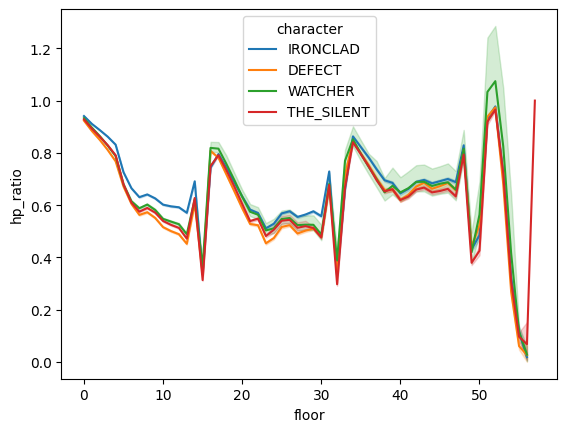

In [11]:
# Interestlingly, player's average hp ratio seems to progress in very similar ways regardless of selected class
df['hp_ratio'] = df['cur_hp'] / df['max_hp']
sns.lineplot(x='floor', y='hp_ratio', hue='character', data=df)

## Correlations and Lasso Regression

What features are likely to be most useful for further modeling?

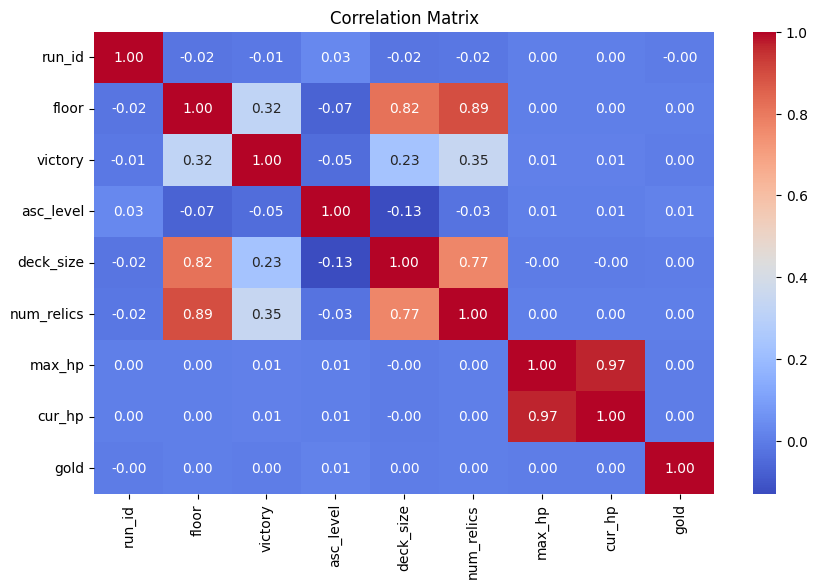

In [12]:
# Generally, correlations with victory are low across the board, but collinearity is also low meaning our features could be independently informative
columns = ['run_id', 'floor', 'victory', 'character', 'asc_level', 'deck_size', 'num_relics', 'max_hp', 'cur_hp', 'gold']
corr = df[columns].corr(numeric_only = True)
plt.figure(figsize = (10,6))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix')
plt.show()

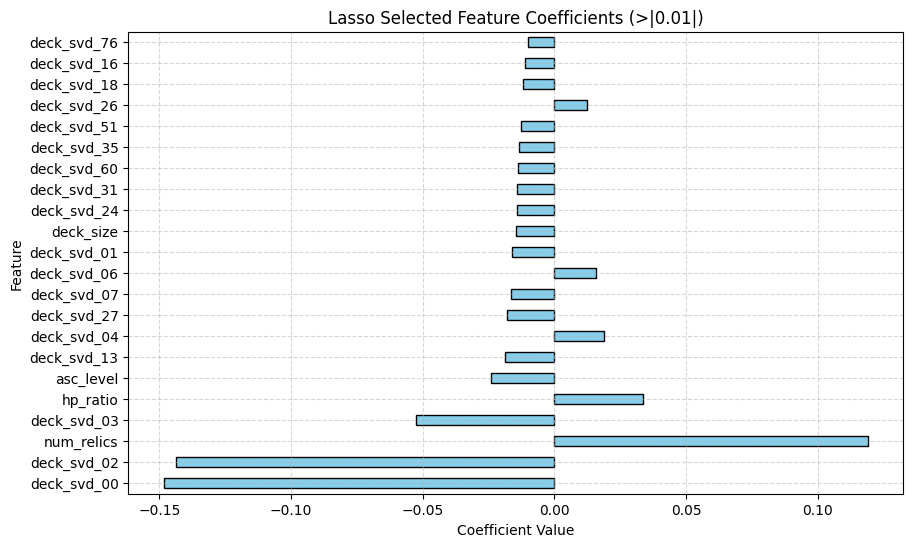

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

y = df['victory']
X = df.drop(columns=['victory'])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = ['character']
numeric_cols = [c for c in numeric_cols if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first'))
        ]), categorical_cols)
    ]
)

lasso_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])

lasso_model.fit(X, y)

ohe_feature_names = (
    lasso_model.named_steps['preprocess']
    .named_transformers_['cat']
    .named_steps['ohe']
    .get_feature_names_out(categorical_cols)
)

feature_names = numeric_cols + list(ohe_feature_names)

coefficients = pd.Series(
    lasso_model.named_steps['lasso'].coef_,
    index=feature_names
)

selected_coefficients = coefficients[coefficients != 0].sort_values(key=abs, ascending=False)

threshold = 0.01
filtered_coefficients = selected_coefficients[abs(selected_coefficients) > threshold]

plt.figure(figsize=(10, 6))
filtered_coefficients.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Lasso Selected Feature Coefficients (>|0.01|)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(linestyle='--', alpha=0.5)
plt.show()



## SVD Analysis

Our first pass with a simple Lasso model shows that several SVD components carry strong predictive signal.
Before relying on them in downstream models, we take a closer look:

- What do the components look like?
- How are they distributed across runs and floors?
- Do they capture recognizable deck evolution patterns?

This section explores those questions and helps us interpret the latent structure uncovered by the SVD.

In [19]:
svd_cols = [c for c in df.columns if c.startswith('deck_svd_')]

# Average by floor to see how decks evolve across progression
svd_floor = (
    df[df['floor'] <= 55]
    .groupby('floor')[svd_cols + ['victory']]
      .mean()
      .reset_index()
)


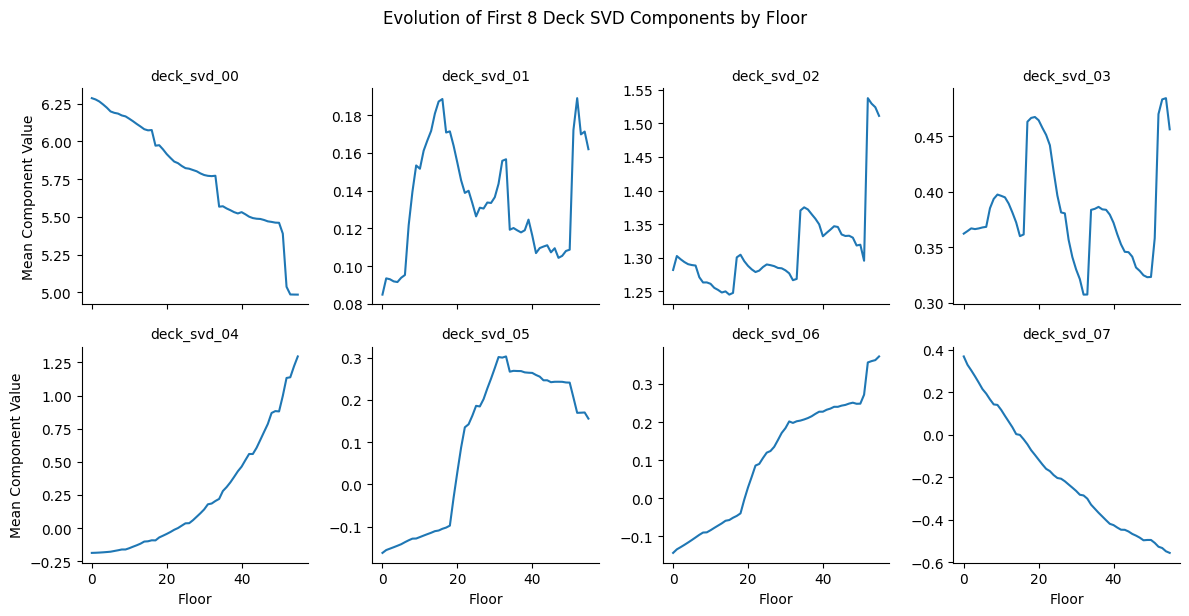

In [20]:
# Long format for first 8 components
svd_long = svd_floor.melt(
    id_vars='floor',
    value_vars=svd_cols[:8],
    var_name='component',
    value_name='value'
)

# 2 rows, 4 columns (8 facets total)
g = sns.FacetGrid(
    svd_long,
    col='component',
    col_wrap=4,     # 4 columns -> 2 rows for 8 components
    sharex=True,
    sharey=False,
    height=3
)
g.map_dataframe(sns.lineplot, x='floor', y='value')
g.set_axis_labels("Floor", "Mean Component Value")
g.set_titles("{col_name}")

g.fig.suptitle("Evolution of First 8 Deck SVD Components by Floor", y=1.02)
plt.tight_layout()
plt.show()


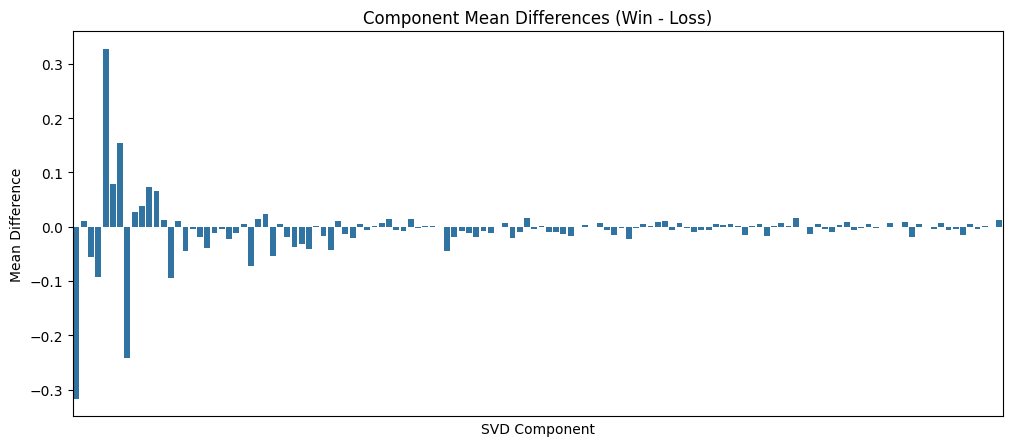

In [21]:
# Compare latent coordinates between winning and losing runs
svd_victory = (
    df.groupby('victory')[svd_cols]
      .mean()
      .T
      .rename(columns={0:'loss',1:'win'})
)
svd_victory['diff'] = svd_victory['win'] - svd_victory['loss']

plt.figure(figsize=(12,5))
sns.barplot(x=svd_victory.index, y='diff', data=svd_victory)
plt.title('Component Mean Differences (Win - Loss)')
plt.xlabel('SVD Component')
plt.ylabel('Mean Difference')
plt.xticks([], [])
plt.show()


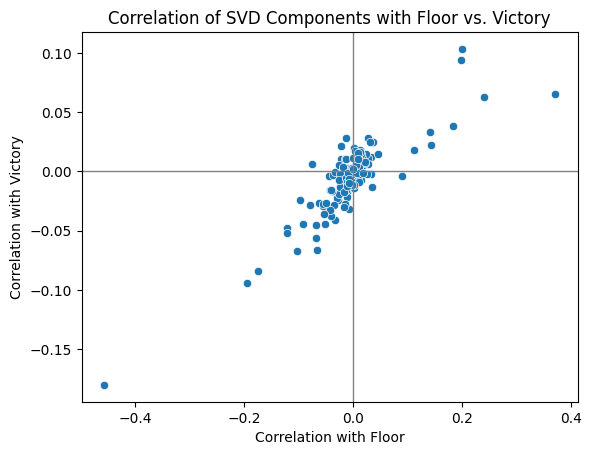

In [22]:
# Interpretation: Components that positively correlate with floor and victory generally are viable win-predictors. Represent how strong a deck is
# Components that positively correlate with floor and negatively with victory are BAD pickups (e.g: Deck Clutter, Curses, etc)
# Components that negative correlate with floor and win-rate are likely indicators of starting deck behavior (Strikes, Defends, Class Starer Cards)
corrs = df[svd_cols + ['victory', 'floor']].corr()[['victory','floor']].iloc[:-2]
corrs.sort_values('victory', ascending=False).head(10)
sns.scatterplot(data=corrs, x='floor', y='victory')
plt.title('Correlation of SVD Components with Floor vs. Victory')
plt.xlabel('Correlation with Floor')
plt.ylabel('Correlation with Victory')
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.show()


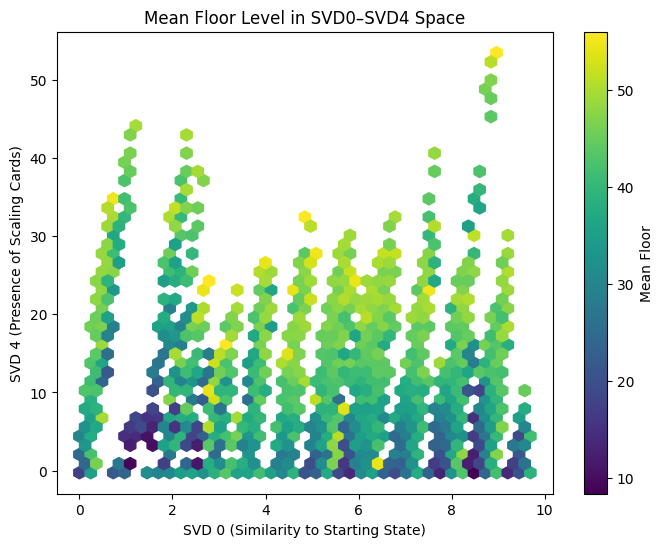

In [34]:
# Awesome confirmation! Higher values of svd_04 strongly indicate how much a deck scales
plt.figure(figsize=(8,6))
hb = plt.hexbin(
    df['deck_svd_00'], df['deck_svd_04'],
    C=df['floor'], reduce_C_function=np.mean,
    gridsize=40, cmap='viridis'
)
plt.colorbar(hb, label='Mean Floor')
plt.xlabel('SVD 0 (Similarity to Starting State)')
plt.ylabel('SVD 4 (Presence of Scaling Cards)')
plt.title('Mean Floor Level in SVD0–SVD4 Space')
plt.show()


In [36]:
# LAST INTERPRETIVE STEP, how do these factors work in a logistic regression?

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import pandas as pd
import numpy as np

# -----------------------------
# Helper function for evaluation
# -----------------------------
def evaluate_model(X, y, model=None, model_name="model"):
    if model is None:
        model = LogisticRegression(max_iter=1000)

    # Get cross-validated predictions (probabilities + labels)
    y_pred_proba = cross_val_predict(
        model, X, y, cv=5, method="predict_proba"
    )[:, 1]

    y_pred = (y_pred_proba >= 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "auc": roc_auc_score(y, y_pred_proba),
    }

    return pd.Series(metrics, name=model_name)

In [37]:
# SVD Only
X1 = df[svd_cols]
y = df["victory"]

res1 = evaluate_model(X1, y, model_name="SVD_only")
res1

,SVD_only
accuracy,0.809775
precision,0.606264
recall,0.197050
auc,0.731312


In [38]:
# 2. MODEL: SVD + floor. Can we glean more information knowing deck state AND how far we are in a run
  # For example, starting deck is OK for first 1-2 floors, but should be terrible in later floors
X2 = df[svd_cols + ["floor"]]
res2 = evaluate_model(X2, y, model_name="SVD_plus_floor")

In [39]:
# 3. MODEL: SVD + floor + character + asc_level
# Last initial test, can we get even more info from the selected character and ascension level


# One-hot encode character
char_enc = OneHotEncoder(sparse_output=False)
char_encoded = char_enc.fit_transform(df[["character"]])

char_cols = [f"char_{c}" for c in char_enc.categories_[0]]

X3 = pd.concat([
    df[svd_cols],
    df[["floor", "asc_level"]].reset_index(drop=True),
    pd.DataFrame(char_encoded, columns=char_cols)
], axis=1)

res3 = evaluate_model(X3, y, model_name="SVD_floor_char_asc")

In [ ]:
# Overall: Low Precision - EXPECTED since deck starting states are all the same. Potential next step, look at predicitons over the course of a run
results = pd.concat([res1, res2, res3], axis=1)
print(results)

           SVD_only  SVD_plus_floor  SVD_floor_char_asc
accuracy   0.809775        0.813137            0.813243
precision  0.606264        0.620355            0.619258
recall     0.197050        0.220429            0.223414
auc        0.731312        0.734272            0.739833
